In [1]:
import squidpy as sq
from anndata import AnnData
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
from numpy.random import default_rng

import matplotlib.pyplot as plt

import pathlib
import warnings
warnings.filterwarnings('ignore')

In [2]:
sample_id = "V19T26-028_C1"
adata = sc.read_visium("./", count_file=f"filtered_feature_bc_matrix.h5")

adata

AnnData object with n_obs × n_vars = 3294 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
adata.var_names_make_unique()
adata.var["MT"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["MT"], inplace=True)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<Axes: xlabel='n_genes_by_counts'>

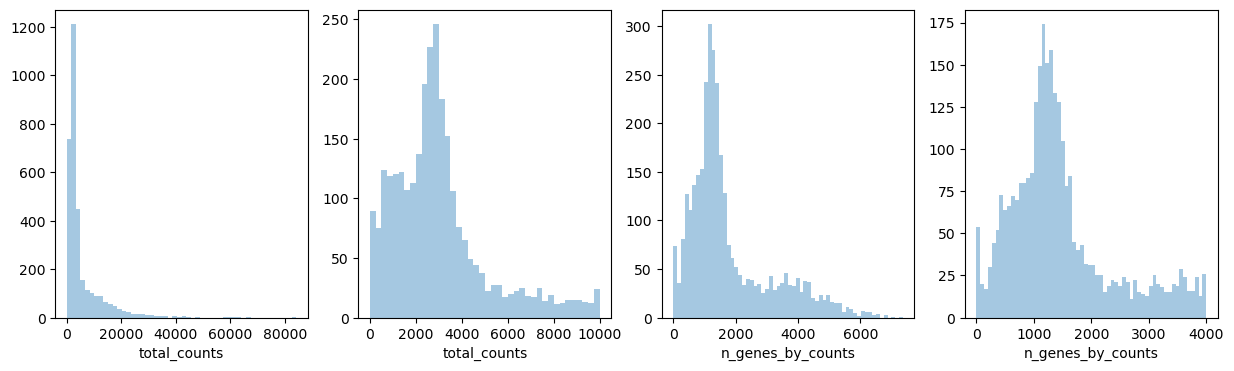

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
    kde=False,
    bins=60,
    ax=axs[3],
)

In [5]:
sc.pp.filter_cells(adata, min_counts=2000)
sc.pp.filter_genes(adata, min_cells=10)

In [6]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=4000)


In [7]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.7)

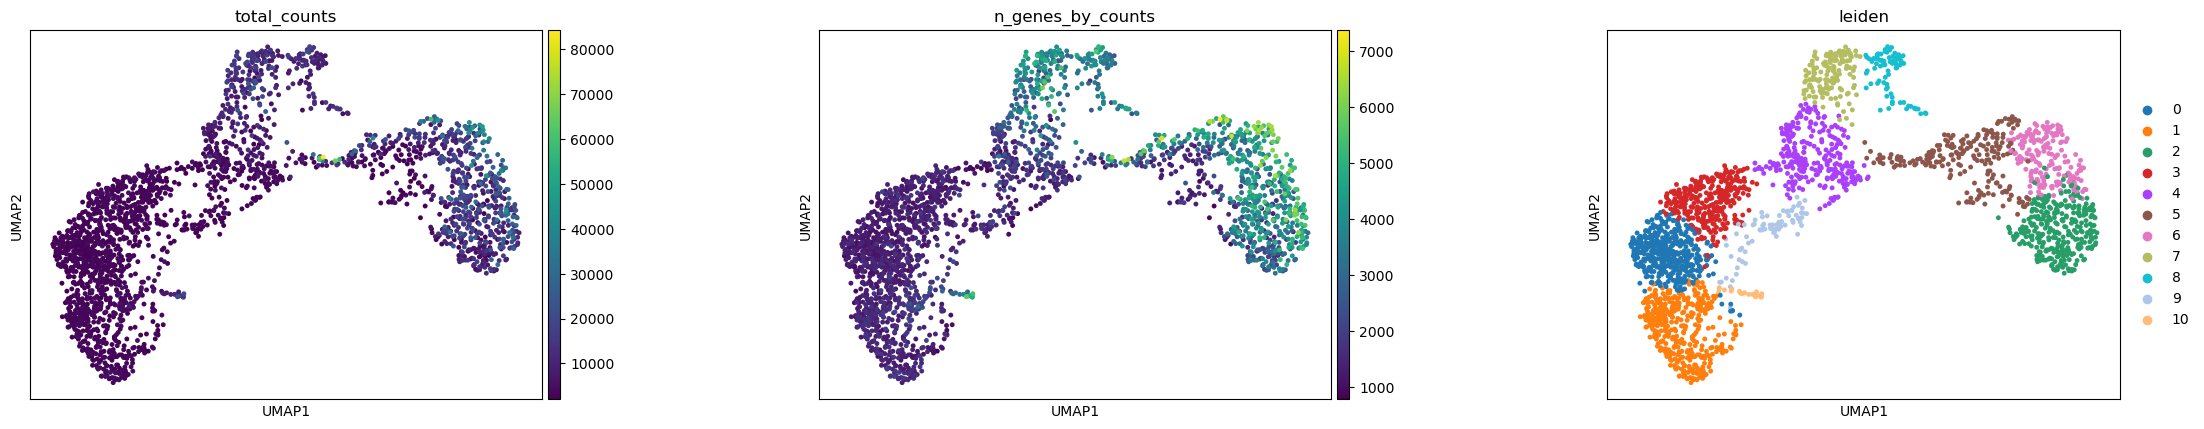

In [8]:
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "leiden"], wspace=0.4)

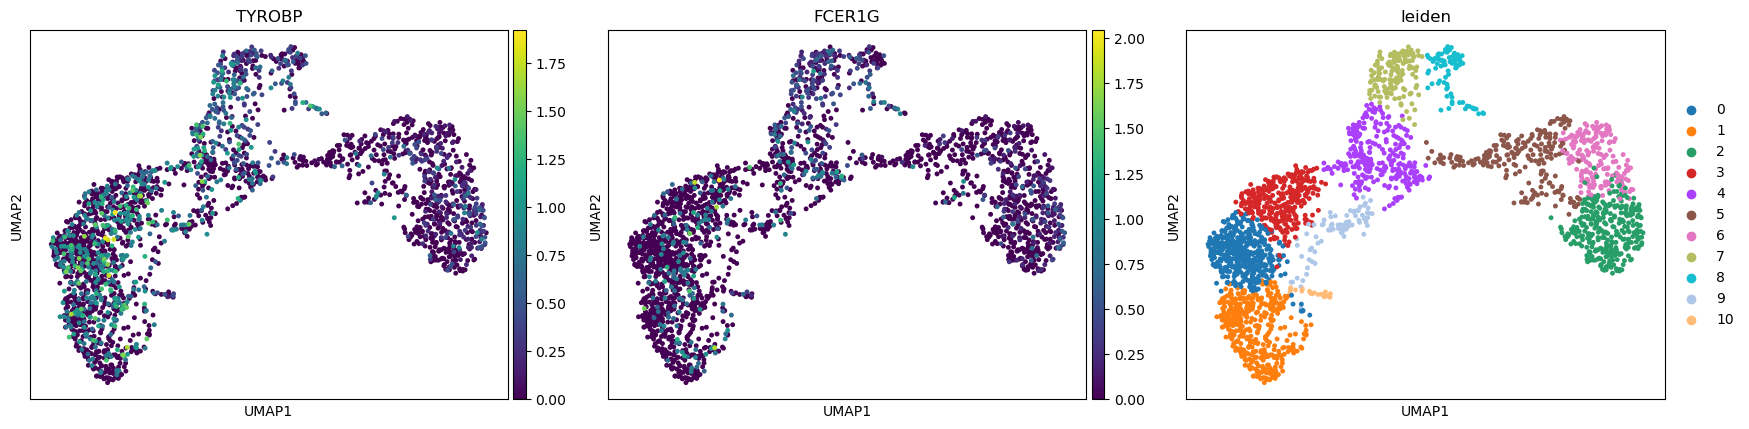

In [9]:
sc.pl.umap(adata, color=["TYROBP", "FCER1G", "leiden"], wspace=0.1)

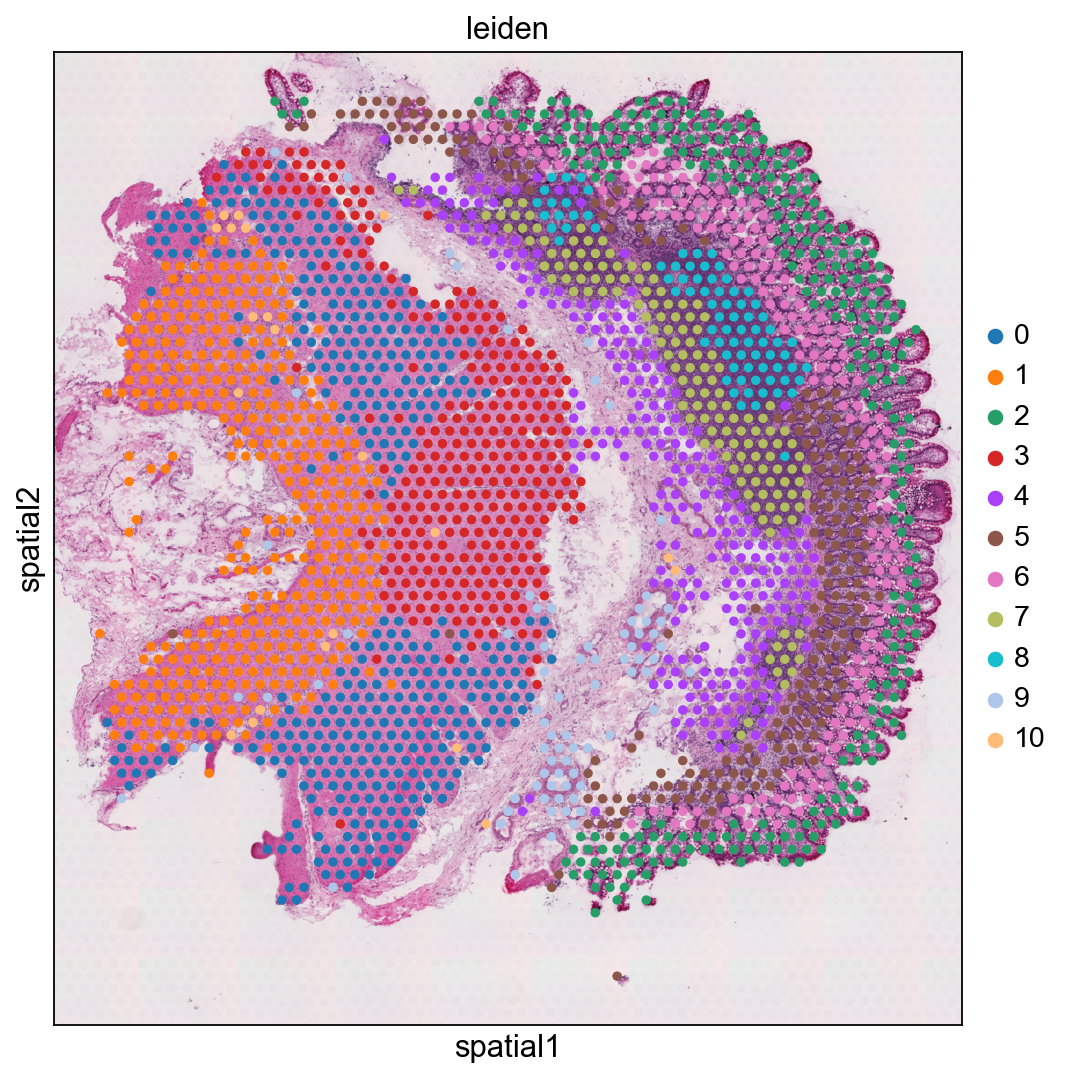

In [10]:
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.pl.spatial(adata, color="leiden")

In [11]:
annotation = {
    "0": "Cluster_0",
    "1": "Cluster_1",
    "2": "Cluster_2",
    "3": "Cluster_3",
    "4": "Cluster_4",
    "5": "Cluster_5",
    "6": "Cluster_6",
    "7": "Cluster_7",
    "8": "Cluster_8",
    "9": "Cluster_9",
    "10": "Cluster_10",
}

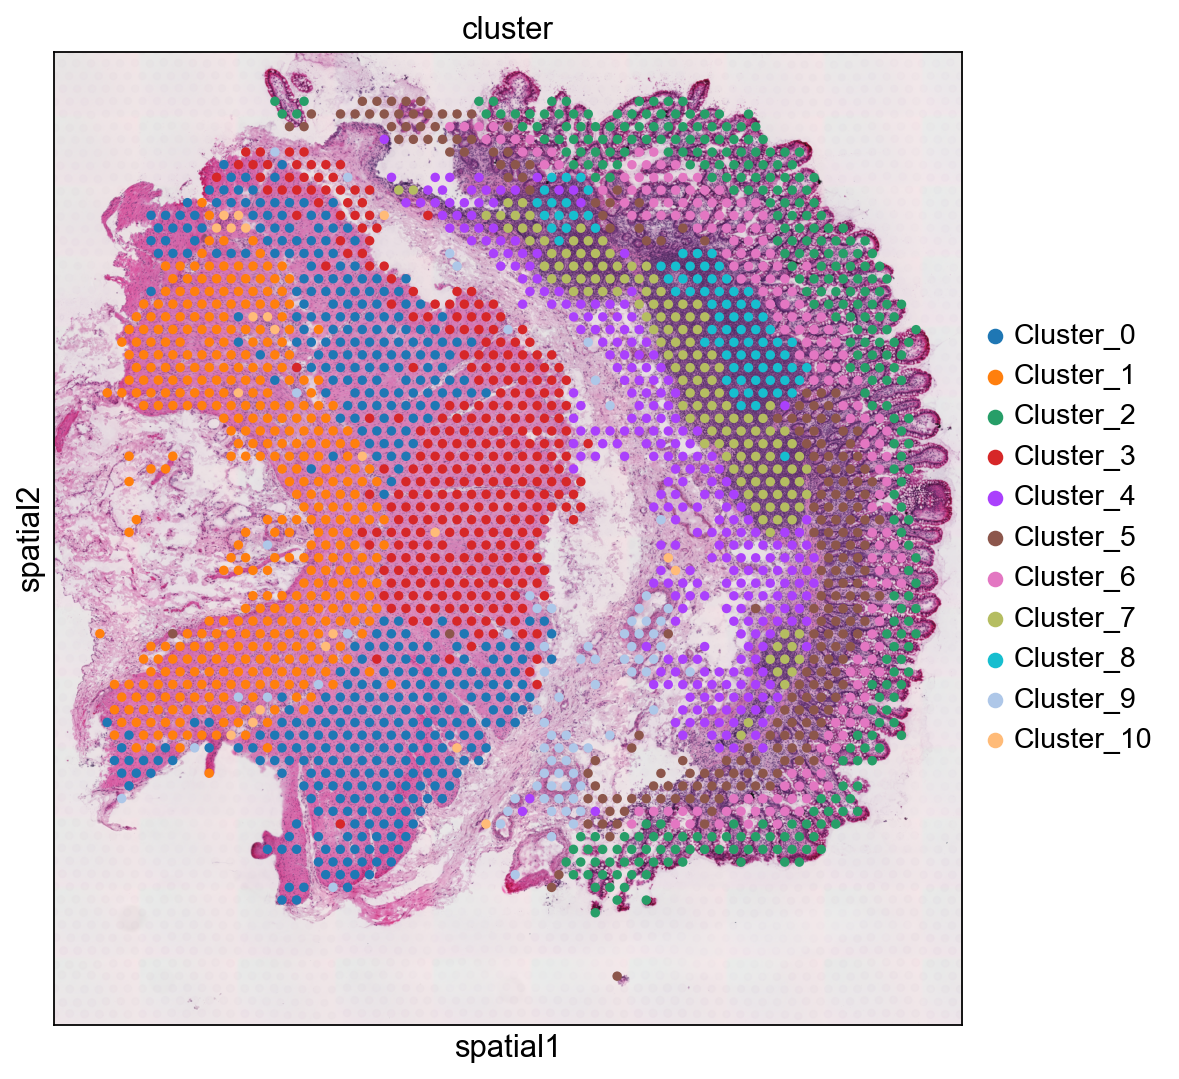

In [12]:
adata.obs["cluster"] = pd.Categorical(adata.obs.leiden.replace(annotation))
sc.pl.spatial(adata, color="cluster")

In [13]:
adata

AnnData object with n_obs × n_vars = 2425 × 16135
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'cluster_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [14]:
img = sq.im.ImageContainer('./spatial/tissue_hires_image.png')

In [15]:
hires = adata.uns['spatial']['V19T26-028_C1']['images']['hires']
lowres = adata.uns['spatial']['V19T26-028_C1']['images']['lowres']

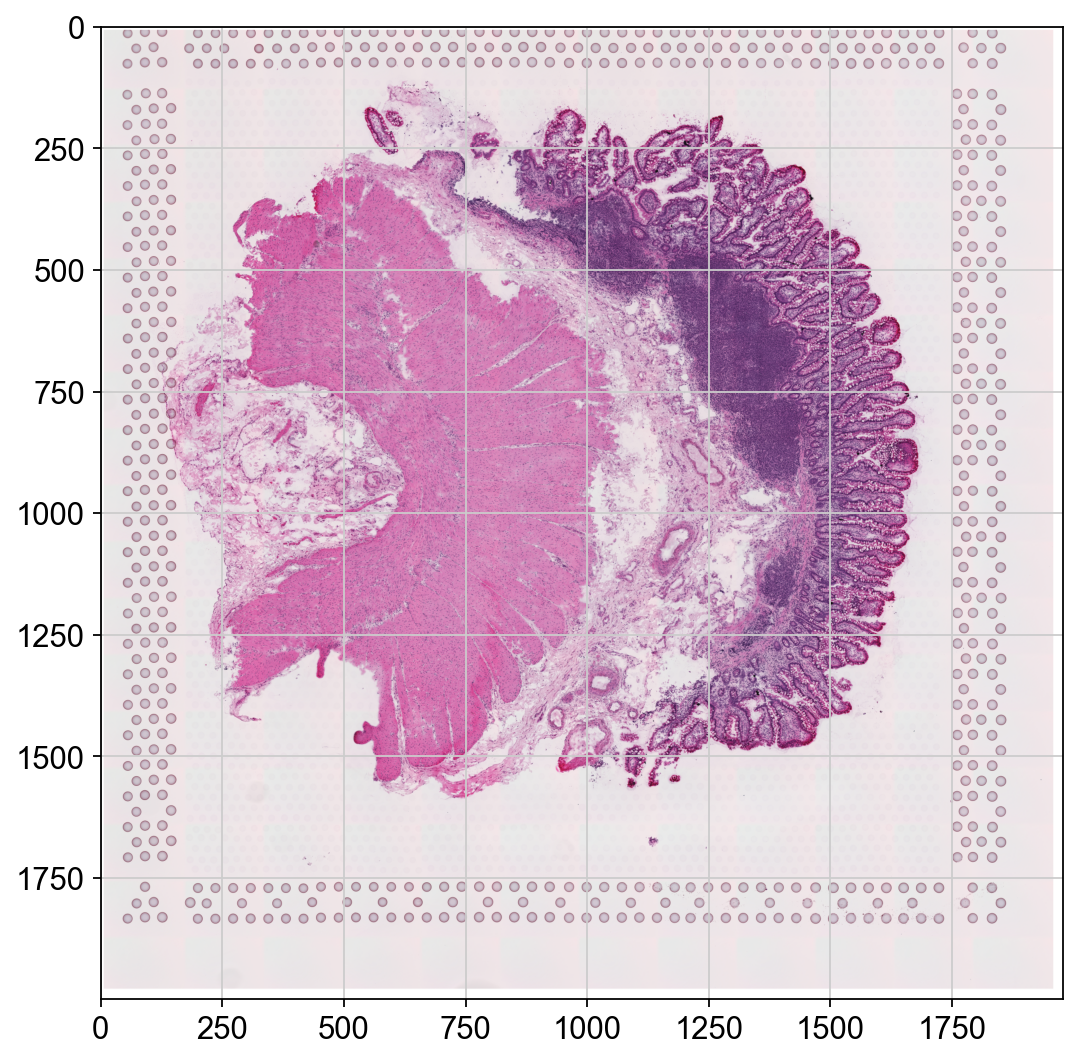

In [16]:
plt.imshow(img['image'][:,:,0])

In [17]:
def crop(arr, x, y, xs, ys):
    return arr[y:y+ys, x:x+xs]

In [ ]:
[(1008, 1304, 66, 60), (796, 1280, 78, 98), (952, 1408, 110, 106)]

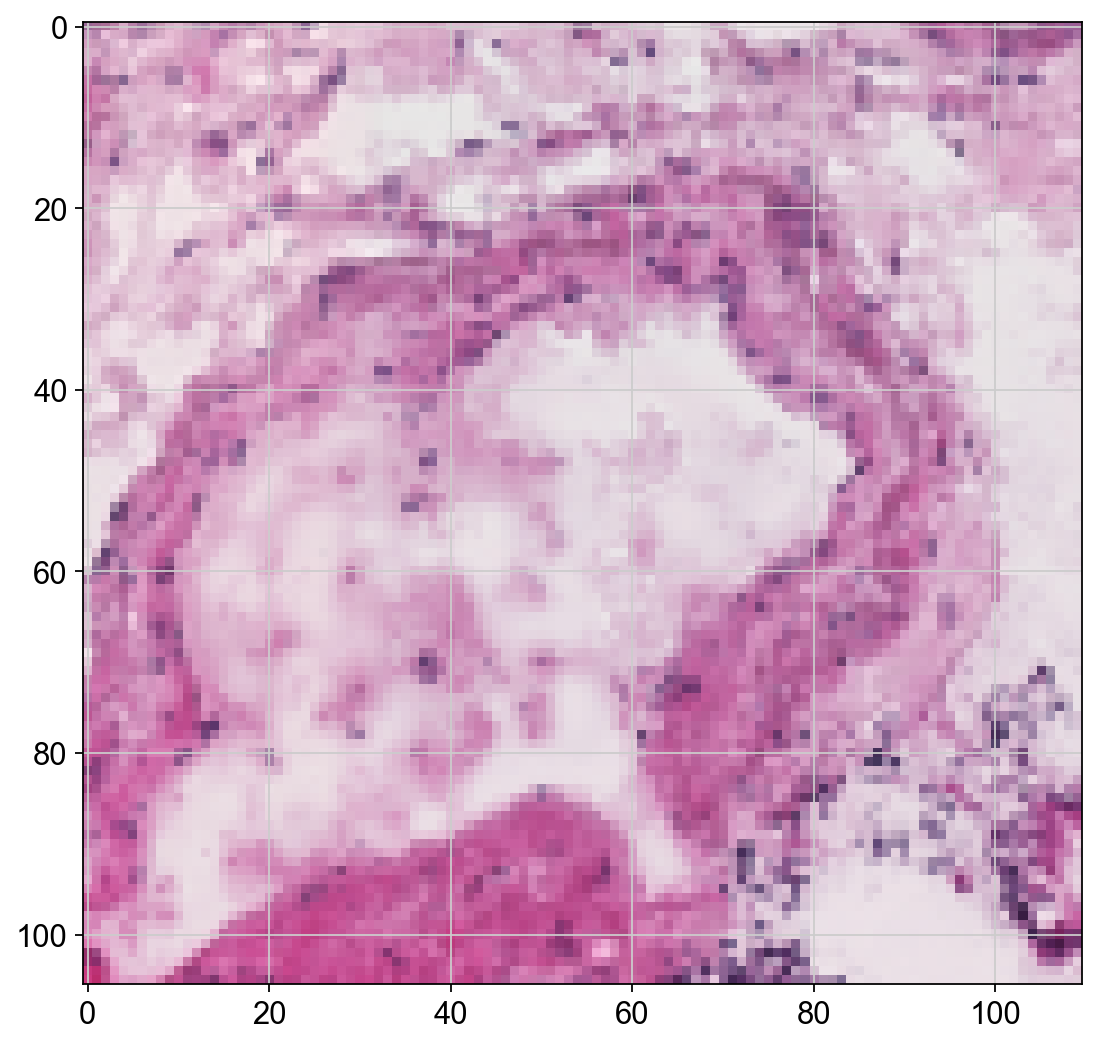

In [26]:
#individual test purpose

crop_cord = [952, 1408, 110, 106]
x_crop = crop_cord[0]
y_crop = crop_cord[1]
xs_crop = crop_cord[2]
ys_crop = crop_cord[3]


plt.imshow(crop(hires, x_crop, y_crop, xs_crop, ys_crop))

Processing crop 1: x=36770, y=25989, xs=2430, ys=1372


/Applications/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/Applications/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


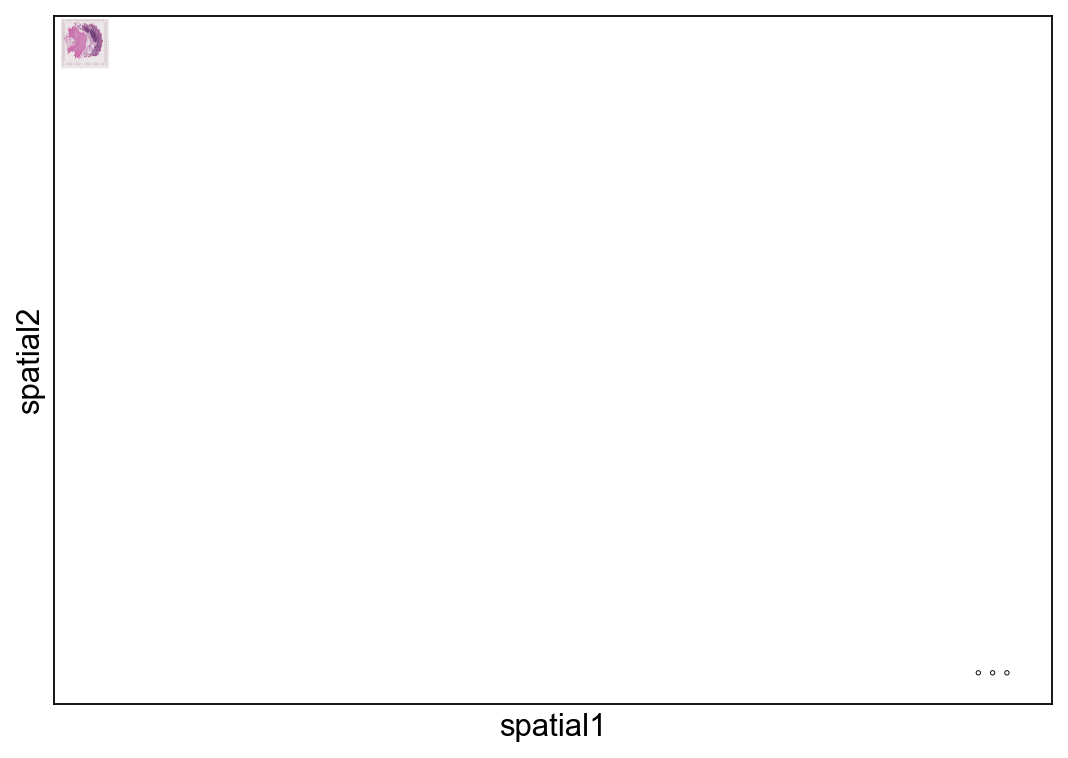

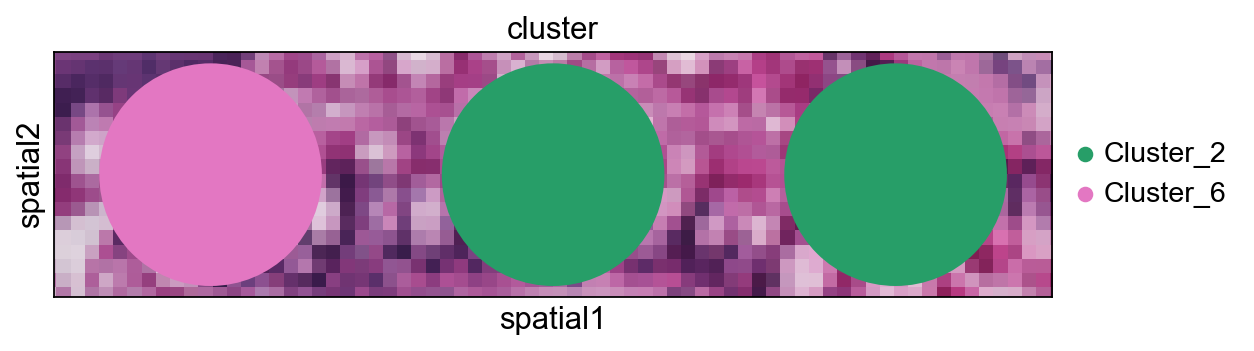

Saved crop 1 to ./patches_output/crop_1_count.csv


In [29]:
import scanpy as sc
import matplotlib.pyplot as plt

def crop_and_save(adata, crop_coords, p_number, p_type, output_dir='./patches_output/'):
    sf_hr = adata.uns['spatial']['V19T26-028_C1']['scalefactors']['tissue_hires_scalef']
    sf_lr = adata.uns['spatial']['V19T26-028_C1']['scalefactors']['tissue_lowres_scalef']

    for i, (x_crop, y_crop, xs_crop, ys_crop) in enumerate(crop_coords):
        x = round(x_crop / sf_hr)
        y = round(y_crop / sf_hr)
        xs = round(xs_crop / sf_hr)
        ys = round(ys_crop / sf_hr)

        print(f"Processing crop {i+1}: x={x}, y={y}, xs={xs}, ys={ys}")

        d = adata.uns['spatial']['V19T26-028_C1']['scalefactors']['spot_diameter_fullres']
        x_mask = (adata.obsm['spatial'][:, 0] < x + xs - d) & (adata.obsm['spatial'][:, 0] > x + d)
        y_mask = (adata.obsm['spatial'][:, 1] < y + ys - d) & (adata.obsm['spatial'][:, 1] > y + d)
        mask = x_mask & y_mask
        
#         plt.imshow(img['image'][:, :, 0])
#         plt.scatter(adata.obsm['spatial'][mask][:, 0], adata.obsm['spatial'][mask][:, 1]) 
        
        adata_cropped = adata[mask].copy()
        sc.pl.spatial(adata_cropped, add_outline=True)
        sc.pl.spatial(adata_cropped, color="cluster")

        df = adata_cropped.to_df().transpose()
        df.to_csv(f'{output_dir}/{p_type}_patch-{p_number}-{i+1}_count.csv', index=True)
        print(f"Saved crop {i+1} to {output_dir}crop_{i+1}_count.csv")

patch_number = 9
patch_type = "crypt"
# patch_type = "gland"
# crop_coords = [(1424, 1292, 83, 81)] # patch 10 crypt
# crop_coords = [(548, 164, 70, 97)] # patch 0 gland; 

# crop_coords = [(916, 168, 94, 119)] # patch 4 crypt
# crop_coords = [(1144, 1008, 90, 114)] # patch 5 gland

# crop_coords = [(952, 1408, 110, 106)] # patch 6 crypt
# crop_coords = [(1008, 1304, 66, 60), (796, 1280, 78, 98)] # patch 6 gland
crop_coords = [(1528, 1080, 101, 57)] # patch 9  

crop_and_save(adata, crop_coords, patch_number, patch_type)
